This notebook is for prototyping subnetwork flow.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

# torch.set_grad_enabled(False)

### Load models

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


In [5]:
prompt = "The capital of Germany is"

mtf_test = PerTokenMaskedTransformer(tl_model, base_prompt=prompt)
print([n for n, p in mtf_test.named_parameters() if p.requires_grad])
with torch.no_grad():
    for name, mask in mtf_test.masks.items():
        if name == "31_mlp_out" or name == "31_attn_pattern":
            print(name, mask.shape)
            continue
        mask *= 0

with torch.no_grad():
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )
    mtf_test.masks_active = False
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )

['masks.0_attn_z', 'masks.0_attn_pattern', 'masks.0_attn_out', 'masks.0_mlp_out', 'masks.1_attn_z', 'masks.1_attn_pattern', 'masks.1_attn_out', 'masks.1_mlp_out', 'masks.2_attn_z', 'masks.2_attn_pattern', 'masks.2_attn_out', 'masks.2_mlp_out', 'masks.3_attn_z', 'masks.3_attn_pattern', 'masks.3_attn_out', 'masks.3_mlp_out', 'masks.4_attn_z', 'masks.4_attn_pattern', 'masks.4_attn_out', 'masks.4_mlp_out', 'masks.5_attn_z', 'masks.5_attn_pattern', 'masks.5_attn_out', 'masks.5_mlp_out', 'masks.6_attn_z', 'masks.6_attn_pattern', 'masks.6_attn_out', 'masks.6_mlp_out', 'masks.7_attn_z', 'masks.7_attn_pattern', 'masks.7_attn_out', 'masks.7_mlp_out', 'masks.8_attn_z', 'masks.8_attn_pattern', 'masks.8_attn_out', 'masks.8_mlp_out', 'masks.9_attn_z', 'masks.9_attn_pattern', 'masks.9_attn_out', 'masks.9_mlp_out', 'masks.10_attn_z', 'masks.10_attn_pattern', 'masks.10_attn_out', 'masks.10_mlp_out', 'masks.11_attn_z', 'masks.11_attn_pattern', 'masks.11_attn_out', 'masks.11_mlp_out', 'masks.12_attn_z', 

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is are The The of The The The The The The The The of The of The The The The The


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


In [6]:
mtf_test.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

assert torch.allclose(cache["resid_pre", 2], cache["resid_post", 30])
assert not torch.allclose(cache["resid_pre", 2], cache["resid_post", 31])
assert torch.allclose(cache["pattern", 2], cache["pattern", 30])
assert not torch.allclose(cache["pattern", 2], cache["pattern", 31])

### Load athlete data

In [103]:
athletes_list = list(set(pd.read_csv("../data/athletes.csv").name))
print("# of athletes:", len(athletes_list))

athletes_by_token_length = collections.defaultdict(list)
for athlete in athletes_list:
    # Tokenize the athlete name and get the token length
    athlete_tokens = tl_model.to_tokens(athlete)[0]
    athlete_len = athlete_tokens.shape[0]
    
    athletes_by_token_length[athlete_len].append(athlete)

print(athletes_by_token_length)
target_len = 5
print(len(athletes_by_token_length[target_len]), athletes_by_token_length[target_len][0])

# of athletes: 268
defaultdict(<class 'list'>, {5: ['Jacques Kallis', 'Alexander Barkov', 'Kyle Connor', 'Andre the Giant', 'Matt Grzelcyk', 'Max Scherzer', 'Mattias Ekholm', 'Apolo Ohno', 'Shane Warne', 'Michael Phelps', 'Patrick Mahomes', 'Mark Scheifele', 'David Pastrnak', 'Daniel Cormier', 'Allen Iverson', 'Usain Bolt', 'Valentino Rossi', 'Scottie Pippen', 'Travis Sanheim', 'Virat Kohli', 'Esa Lindell', 'Albert Pujols', 'Jonathan Toews', 'Kobe Bryant', 'Keith Yandle', 'Quinn Hughes', 'Jake Gardiner', 'Andre Agassi', 'Aaron Rodgers', 'Zach Werenski', 'Shea Theodore', 'Ivan Provorov', 'Kyrie Irving', 'Georges St-Pierre', 'John Tavares', 'Lindsey Vonn', 'Matthew Barzal', 'Stone Cold Steve Austin', 'Hulk Hogan', 'Marco Scandella', 'Cam Fowler', 'Wasim Akram', 'Roman Reigns', 'Monica Seles', 'Henry Cejudo', 'Steffi Graf', 'Jakob Chychrun', 'Brock Lesnar', 'Jacob deGrom', 'Amanda Nunes', 'Oscar Klefbom', 'Kawhi Leonard', 'LeBron James', 'Neymar Jr', 'Vladimir Guerrero', 'Michael Schumach

### Do optimization

In [122]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>

Complete the statement. {question} [/INST] \
"""


all_prompts = [
    get_corr_prompt(f"{athlete} plays the sport of", correct=True)
    for athlete in athletes_by_token_length[4]
]
all_prompt_tokens = torch.stack([tl_model.to_tokens(p)[0] for p in all_prompts])
mtf = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=all_prompts[0],
)

with torch.no_grad():
    logits = mtf.tl_model.forward(all_prompt_tokens, return_type="logits")[:, -1]
    probs = torch.softmax(logits, dim=-1)
    all_correct_tokens = torch.argmax(logits, dim=-1)
    all_correct_probs = probs[
        torch.arange(len(all_correct_tokens)), all_correct_tokens
    ]

all_correct_strs = [mtf.tl_model.to_string(t) for t in all_correct_tokens]
print(collections.Counter(all_correct_strs))

# Filter to good sports
mask = [
    (len(s) > 2 and p > 0.95)
    for s, p in zip(all_correct_strs, all_correct_probs)
]
all_prompts = [p for p, m in zip(all_prompts, mask) if m]
all_prompt_tokens = all_prompt_tokens[mask]
all_correct_tokens = all_correct_tokens[mask]
all_correct_probs = all_correct_probs[mask]
all_correct_strs = [mtf.tl_model.to_string(t) for t in all_correct_tokens]

# Print statistics of all_correct_strs
print(collections.Counter(all_correct_strs))

print(
    all_prompt_tokens.shape, all_correct_tokens.shape, all_correct_tokens.dtype
)
print(all_prompts[0])
utils.get_top_responses(
    prompt=all_prompts[0],
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
)

optim = torch.optim.Adam(mtf.masks.parameters(), lr=1e-2)

Counter({'Hockey': 15, 'Basketball': 13, 'Football': 5, 'Tennis': 5, 'Baseball': 5, 'G': 3, 'Cr': 3, 'Soccer': 2, 'Wrestling': 1, 'Ice': 1, 'Formula': 1, 'Ski': 1})
Counter({'Hockey': 13, 'Basketball': 11, 'Tennis': 5, 'Baseball': 5, 'Football': 4, 'Soccer': 1, 'Ski': 1})
torch.Size([40, 52]) torch.Size([40]) torch.int64
[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Stephen Curry plays the sport of [/INST] 
Rank 0. Logit: 27.09 Prob: 99.71% Tokens: (21850) |Basketball|</s>|
Rank 1. Logit: 20.90 Prob:  0.21% Tokens: (13402) |Ball|</s>|
Rank 2. Logit: 19.98 Prob:  0.08% Tokens: (20305) |basketball|</s>|
Rank 3. Logit: 16.32 Prob:  0.00% Tokens: (21517) |NBA|</s>|
Rank 4. Logit: 16.13 Prob:  0.00% Tokens: (  376) |"|B|asketball|"|</s>|


In [123]:
# Initialize optimizer
alpha = 0.1
n_steps = 400
p_norm = 1
batch_size = 13

np.random.seed(42)

metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))
for i in pbar:
    # Sample 13 random indices
    batch_indices = np.random.choice(
        len(all_prompt_tokens), size=batch_size, replace=False
    )
    batch_prompts = all_prompt_tokens[batch_indices]
    batch_correct_tokens = all_correct_tokens[batch_indices]

    logits = mtf.tl_model.forward(
        batch_prompts, return_type="logits"
    )  # shape [batch_size, seq_len, vocab_size]
    logits = logits[
        :, -1, :
    ]  # Taking logits corresponding to the last token for all prompts in the batch

    # Compute target log probabilities
    # Assume correct_token is a list containing the correct tokens for each prompt
    target_log_prob = torch.log_softmax(logits, dim=-1)[
        range(batch_size), batch_correct_tokens
    ]  # shape [batch_size]

    # todo - compute average target log prob over all prompts
    avg_target_log_prob = target_log_prob.mean()

    # Regularization term calculations remain the same
    mask_p_norm = sum(
        (mask**p_norm).sum() for mask in mtf.masks.values()
    ) ** (1 / p_norm)
    mask_nonzero = sum((mask > 0).sum() for mask in mtf.masks.values())
    mask_numel = sum(mask.numel() for mask in mtf.masks.values())
    density = mask_nonzero / mask_numel
    scaled_p_norm = alpha * min(2 * i / n_steps, 1) * mask_p_norm

    # todo - use average target log prob over all prompts instead of just one
    loss = -avg_target_log_prob + scaled_p_norm

    # Gradient update step
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in mtf.masks.values():
            mask.clamp_(0, 1)

    # Logging
    metrics = dict(
        step=i,
        loss=loss.item(),
        avg_target_log_prob=avg_target_log_prob.item(),
        avg_target_prob=torch.exp(target_log_prob).mean().item(),
        scaled_p_norm=scaled_p_norm.item(),
        mask_p_norm=mask_p_norm.item(),
        mask_nonzero=mask_nonzero.item(),
        mask_numel=mask_numel,
        density=density.item(),
    )
    metric_history.append(metrics)
    pbar.set_postfix(metrics)

  0%|          | 0/400 [00:00<?, ?it/s]

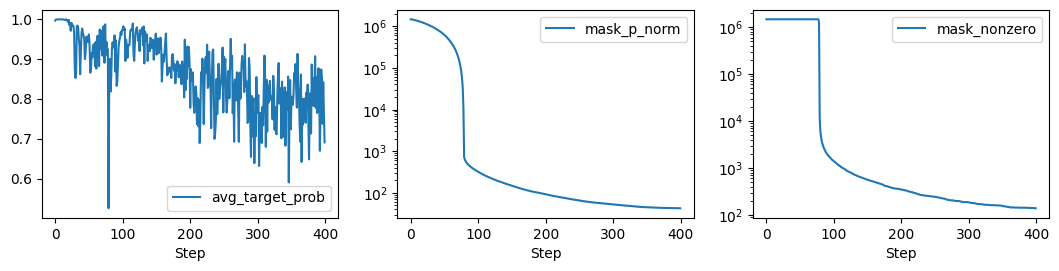

In [127]:
df = pd.DataFrame(metric_history)

plt.figure(figsize=(13, 2.7))
plt.subplot(1, 3, 1)
df.avg_target_prob.plot()
plt.legend()
plt.xlabel("Step")

plt.subplot(1, 3, 2)
df.mask_p_norm.plot()
plt.yscale("log")
plt.legend()
plt.xlabel("Step")

plt.subplot(1, 3, 3)
df.mask_nonzero.plot()
plt.yscale("log")
plt.legend()
plt.xlabel("Step")

plt.show()

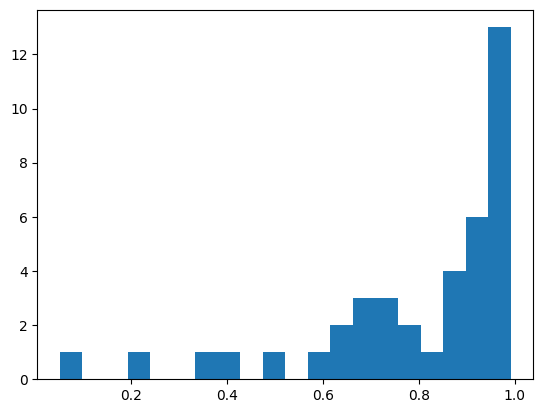

In [132]:
# Analyze performance on multiple people
with torch.no_grad():
    logits = mtf.tl_model.forward(all_prompt_tokens, return_type="logits")[:, -1]
    target_probs = torch.softmax(logits, dim=-1)[
        torch.arange(len(all_correct_tokens)), all_correct_tokens
    ].detach().cpu().numpy()

plt.hist(target_probs, bins=20)
plt.show()

In [138]:
prompt = all_prompts[22]
print(prompt)
utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
    n_continuation_tokens=1,
)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Victor Hedman plays the sport of [/INST] 
Rank 0. Logit: 15.85 Prob: 64.53% Tokens: (19993) |Hockey|att|
Rank 1. Logit: 14.35 Prob: 14.44% Tokens: ( 8914) |Football|mid|
Rank 2. Logit: 14.06 Prob: 10.85% Tokens: (21850) |Basketball|ss|
Rank 3. Logit: 12.86 Prob:  3.27% Tokens: (23185) |Baseball|ss|
Rank 4. Logit: 12.13 Prob:  1.56% Tokens: (18993) |Soccer|att|


### Visualize remaining flow

In [139]:
attn_mask = np.stack(
    [mtf.masks[f"{i}_attn_out"].detach().cpu().numpy() for i in range(32)]
)
attn_z_mask = np.stack(
    [mtf.masks[f"{i}_attn_z"].detach().cpu().numpy() for i in range(32)], axis=0
)
attn_pattern_mask = np.stack(
    [mtf.masks[f"{i}_attn_pattern"].detach().cpu().numpy() for i in range(32)],
)
mlp_mask = np.stack(
    [mtf.masks[f"{i}_mlp_out"].detach().cpu().numpy() for i in range(32)]
)

attn_z_mask *= (attn_mask > 0)[:, :, np.newaxis]
attn_mask.shape, attn_z_mask.shape, attn_pattern_mask.shape, mlp_mask.shape

((32, 52), (32, 52, 32), (32, 32, 52, 52), (32, 52))

<s>|[|INST|]|<<|SY|S|>>|
|You|are|an|assistant|who|only|respond|s|with|a|single|word|.|You|only|give|correct|answers|.|
|<|</|SY|S|>>|
|
|Complete|the|statement|.|Victor|Hed|man|plays|the|sport|of|[|/|INST|]|
Layer 0, head 25, token 48: weight=0.758306
Layer 1, head 24, token 42: weight=0.69329655
Layer 1, head 27, token 42: weight=0.626554
Layer 2, head 8, token 42: weight=0.58403724
Layer 2, head 13, token 42: weight=0.47299984
Layer 2, head 16, token 42: weight=0.3573986
Layer 2, head 24, token 42: weight=0.46487227
Layer 3, head 23, token 42: weight=0.42720845
Layer 3, head 5, token 50: weight=0.6394479
Layer 3, head 28, token 51: weight=0.4716562
Layer 4, head 4, token 51: weight=0.35290202
Layer 4, head 7, token 51: weight=0.30239218
Layer 4, head 8, token 51: weight=0.572967
Layer 4, head 27, token 51: weight=0.41054487
Layer 6, head 1, token 42: weight=0.46339172
Layer 7, head 25, token 51: weight=0.39747676
Layer 8, head 29, token 51: weight=0.5940954
Layer 10, head 15, token 

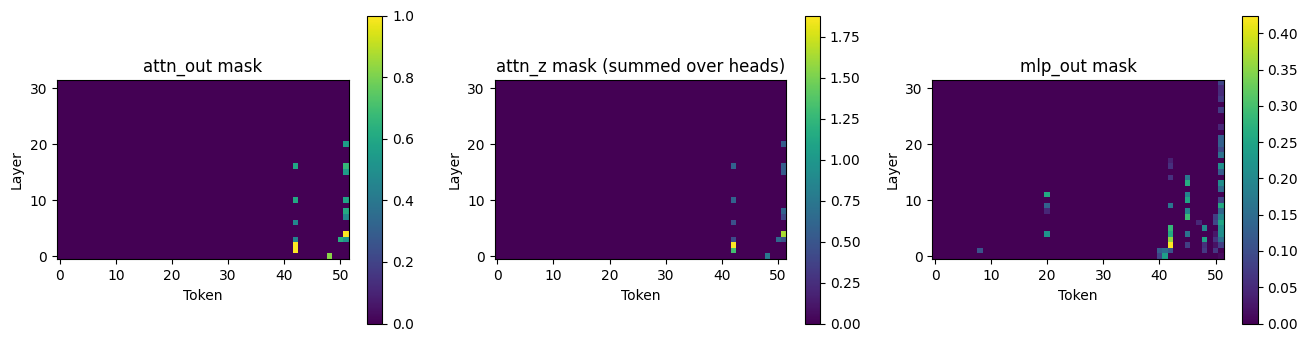

In [140]:
# Plot heatmap of attention mask
subtokens = mtf.tl_model.to_tokens(prompt)[0, mtf.mask_start_idx :]
tokenized_subprompt = "|".join(mtf.tl_model.to_string(x) for x in subtokens)
print(tokenized_subprompt)

for layer_idx in range(32):
    for token_idx in range(mtf.n_tokens):
        for head_idx in range(mtf.tl_model.cfg.n_heads):
            weight = attn_z_mask[layer_idx, token_idx, head_idx]
            if weight > 0:
                print(
                    f"Layer {layer_idx},"
                    f" head {head_idx},"
                    f" token {token_idx}:"
                    f" {weight=}"
                )

for layer_idx in range(32):
    for head_idx in range(mtf.tl_model.cfg.n_heads):
        for token_idx_q in range(mtf.n_tokens):
            for token_idx_k in range(mtf.n_tokens):
                weight = attn_pattern_mask[
                    layer_idx, head_idx, token_idx_q, token_idx_k
                ]
                if weight > 0:
                    q_token = mtf.tl_model.to_string(subtokens[token_idx_q])
                    k_token = mtf.tl_model.to_string(subtokens[token_idx_k])
                    print(
                        f"Layer {layer_idx},"
                        f" head {head_idx},"
                        f" token_q {token_idx_q} ({q_token})"
                        f" token_k {token_idx_k} ({k_token}):"
                        f" {weight=}"
                    )

plt.figure(figsize=(16, 4))
# plt.suptitle(tokenized_subprompt)

plt.subplot(1, 3, 1)
plt.imshow(attn_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_out mask")

plt.subplot(1, 3, 2)
plt.imshow(attn_z_mask.sum(axis=-1), origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_z mask (summed over heads)")

plt.subplot(1, 3, 3)
plt.imshow(mlp_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("mlp_out mask")

plt.show()

### Analyze thresholding

In [ ]:
all_mask_values = (
    torch.cat([mask.flatten() for mask in mtf.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

thresholds = np.unique(
    np.sort(np.concatenate([all_mask_values, np.array([0, 1])]))
)
thresh_metrics = []
for thresh in tqdm(thresholds):
    mtf.zero_threshold = thresh
    mtf.one_threshold = 1
    with torch.no_grad():
        target_prob_0 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    mtf.zero_threshold = 0
    mtf.one_threshold = max(thresh, 1e-9)
    with torch.no_grad():
        target_prob_1 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    thresh_metrics.append(
        dict(
            threshold=thresh,
            target_prob_0=target_prob_0.item(),
            target_prob_1=target_prob_1.item(),
            n_nonzero=(all_mask_values > thresh).sum(),
            n_ones=(all_mask_values > thresh).sum(),
        )
    )

In [ ]:
df_thresh = pd.DataFrame(thresh_metrics)

print("# nonzero mask values:", (all_mask_values > 0).sum())
print("# total mask values:", all_mask_values.size)

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.title("CDF of Mask Values")

plt.subplot(2, 3, 2)
plt.plot(df_thresh.threshold, df_thresh.target_prob_0)
plt.yscale("log")
plt.xlabel("0 Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 3)
plt.plot(df_thresh.n_nonzero, df_thresh.target_prob_0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# non-zero mask values")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 5)
plt.plot(df_thresh.threshold, df_thresh.target_prob_1)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 6)
plt.plot(df_thresh.n_ones, df_thresh.target_prob_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# ones")
plt.ylabel("Target Prob")
plt.show()